# Wykrywanie naczyń dna siatkówki oka

In [167]:
from IPython.display import display
import PIL
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img
from numpy import asarray
import skimage
from skimage.exposure import equalize_hist
from skimage.filters import unsharp_mask
from skimage.morphology import erosion, disk, square, dilation, closing
import scipy
from skimage import data, filters, exposure, feature
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.stats import gmean
from statistics import mean
from PIL import Image, ImageChops
import random

## Pozyskanie przykładowych obrazów

In [121]:
import os

input_dir = f"{os.getcwd()}/images/"
target_dir = f"{os.getcwd()}/labels/"

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".ppm")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".ppm") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:2], target_img_paths[:2]):
    print(input_path, "|", target_path)

Number of samples: 20
C:\repos\IWM\retinal-segmentation-na-3/images/im0001.ppm | C:\repos\IWM\retinal-segmentation-na-3/labels/im0001.ah.ppm
C:\repos\IWM\retinal-segmentation-na-3/images/im0002.ppm | C:\repos\IWM\retinal-segmentation-na-3/labels/im0002.ah.ppm


## Przykładowy obraz

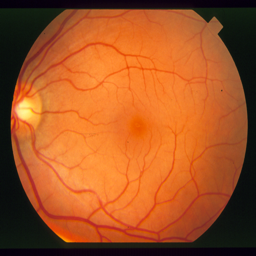

In [145]:
i = 6
image = Image.open(input_img_paths[i])
display(image.resize((256, 256)))

## Przykładowy oczeikwany wynik

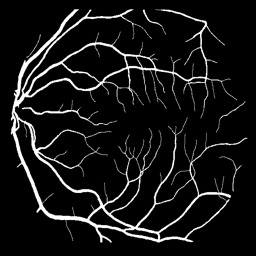

In [146]:
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img.resize((256, 256)))

# Transformacje morfologiczne

Zastosowaliśmy przekształcenia morfologiczne w dwóch konfiguracjach.

In [147]:
def morph_1(img):
    inv = ImageChops.invert(img)

    img = asarray(inv)
    img = rgb2gray(img)

    img = equalize_hist(img)   # normalize histogram 

    img = unsharp_mask(img, radius=6, amount=3)   # sharpen

    img =  dilation(skimage.feature.canny(img, sigma=3.5))

    img = closing(img, disk(3))
    
    return img

def morph_2(img):
    img = asarray(img)
    img = rgb2gray(img)

    img2 = equalize_hist(img)   # normalize histogram 

    x = 4
    kernel = np.ones((x,x),np.uint8)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    img = filters.sobel(img) #  sobel

    x = 8
    K = np.ones([x,x])
    K = K / sum(K)
    img = convolve(img, K)

    x = 4
    kernel = np.ones((x,x),np.uint8)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    img = unsharp_mask(img, radius=64, amount=8)   # sharpen
    return img

In [169]:
stats = ['Accuracy', 'Sensitivity', 'Specificity', 'Geometric']

def binary_mask(img, thresh=0.1):
    img = img.copy()
    img[img[:, :] > img * thresh] = 1
    img[img[:, :] < img * thresh] = 0
    return erosion(img, disk(2))

def get_statistics(img, mask):
    (w, h) = img.shape

    tp, fp, fn, tn = 0, 0, 0, 0
    for x in range(w):
        for y in range(h):
            if (img[x, y]):
                if (mask[x, y]):
                    tp += 1
                else:
                    fp += 1
            else:
                if (mask[x, y]):
                    fn += 1
                else:
                    tn += 1

    return tp, fp, fn, tn

def get_metrics(img, mask, thresh=0.1):
    img_bool = img > thresh
    mask_bool = mask > thresh

    tp, fp, fn, tn = get_statistics(img_bool, mask_bool)
    
    accuracy = (tp + tn) / (tn + fn + tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    geometric = gmean([sensitivity, specificity])

    return accuracy, sensitivity, specificity, geometric

def print_stats(stats, i):
    print(f"Image no. {i}") 
    print(f"Accuracy: {stats[0]}")
    print(f"Sensitivity: {stats[1]}")    
    print(f"Specificity: {stats[2]}")
    print(f"Geometric: {stats[3]}")

Segmented vessels:


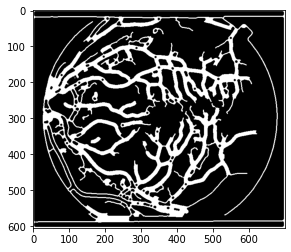

In [161]:
print("Segmented vessels:")
img = morph_1(Image.open(input_img_paths[i]))
plt.imshow(img, cmap='gray');

Image no. 6
Accuracy: 0.890344746162928
Sensitivity: 0.37020728617122917
Specificity: 0.9570618669309505
Geometric: 0.5952405198358705


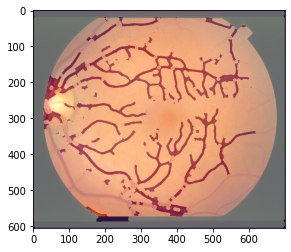

In [163]:
mask = binary_mask(img)

plt.imshow(load_img(input_img_paths[i]))
plt.imshow(img * mask, cmap='Purples', alpha=0.4)

stats = get_metrics(asarray(Image.open(target_img_paths[i])), mask)
print_stats(stats, i)

Segmented vessels:


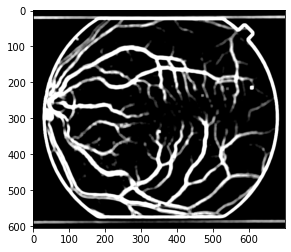

In [164]:
img = morph_2(Image.open(input_img_paths[i]))

print("Segmented vessels:")
plt.imshow(img, cmap='gray');

Jak widać, wygenerowany obraz jest o wiele mniej wyraźny oraz nie pomija konturu obwodu oka, co znacząco wpływa na wyniki. Jednakże otrzymuje wyższy wynik specyficzności w porównaniu do metody poprzedniej ze względu na wykrywanie również mniejszych naczyć. Wiąże się to jednak z występowaniem artefaktów.

Image no. 6
Accuracy: 0.847582054309327
Sensitivity: 0.33539130060663425
Specificity: 0.9916527495401297
Geometric: 0.5767076429339297


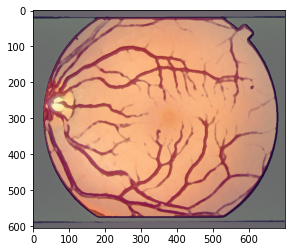

In [165]:
mask = binary_mask(img)


plt.imshow(load_img(input_img_paths[i]))
plt.imshow(img * mask, cmap='Purples', alpha=0.4)

stats = get_metrics(asarray(Image.open(target_img_paths[i])), mask)
print_stats(stats, i)

In [176]:
imgs = random.sample(range(20), 10)
history1 = []
history2 = []

for i in imgs:
    img = Image.open(input_img_paths[i])
    vessels1 = morph_1(img)
    vessels2 = morph_2(img)
    
    mask1 = binary_mask(vessels1)
    mask2 = binary_mask(vessels2)
    
    stats1 = get_metrics(asarray(Image.open(target_img_paths[i])), mask1)
    stats2 = get_metrics(asarray(Image.open(target_img_paths[i])), mask2)
    
    history1.append((stats1))
    history2.append((stats2))
    
print("Method 1:")
for i, stat in enumerate(stats):
    print(f"  {stat}: {mean([x[i] for x in history1])}")
print('')
print("Method 2:")
for i, stat in enumerate(stats):
    print(f"  {stat}: {mean([x[i] for x in history2])}")

Method 1:
  Accuracy: 0.903682880755608
  Sensitivity: 0.40135350244703905
  Specificity: 0.9535453925024165
  Geometric: 0.6112938479103058

Method 2:
  Accuracy: 0.8262821723730814
  Sensitivity: 0.27115613787146603
  Specificity: 0.9778374011612325
  Geometric: 0.5114746035874392
